### 1. Feature importance признаков

In [28]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
df = pd.read_csv("adult.data")
print(df.shape)
df.head(3)

(32560, 15)


,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   39              32560 non-null  int64 
 1    State-gov      32560 non-null  object
 2    77516          32560 non-null  int64 
 3    Bachelors      32560 non-null  object
 4    13             32560 non-null  int64 
 5    Never-married  32560 non-null  object
 6    Adm-clerical   32560 non-null  object
 7    Not-in-family  32560 non-null  object
 8    White          32560 non-null  object
 9    Male           32560 non-null  object
 10   2174           32560 non-null  int64 
 11   0              32560 non-null  int64 
 12   40             32560 non-null  int64 
 13   United-States  32560 non-null  object
 14   <=50K          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [4]:
df.head()

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [32]:
df.describe(include='object')

,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
count,32560,32560,32560,32560,32560,32560,32560,32560,32560
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27815,21789,29169,24719


In [35]:
CAT_FEATURE_NAMES = df.select_dtypes(include=['object']).columns
SELECTED_FEATURE_NAMES = df.columns
NUM_FEATURE_NAMES = df.select_dtypes(include=['int']).columns

In [36]:
t = CAT_FEATURE_NAMES
for tt in t:
    k = 0
    for i in df[tt].unique():
        df.loc[df[tt] == i, tt] = k
        k = k + 1
    df[tt]=  pd.to_numeric(df[tt], errors='coerce')

В качестве предикторов (признаков) будем использовать 4 - bedrooms, sqft_living, sqft_lot и yr_built

Целевая переменная - price (цена)

In [50]:
target = ' <=50K'
features = df.columns.drop(target).tolist()
CAT_FEATURE_NAMES = CAT_FEATURE_NAMES.drop(target).tolist()

#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], random_state=0)

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt

In [73]:
NUM_FEATURE_NAMES

Index(['39', ' 77516', ' 13', ' 2174', ' 0', ' 40'], dtype='object')

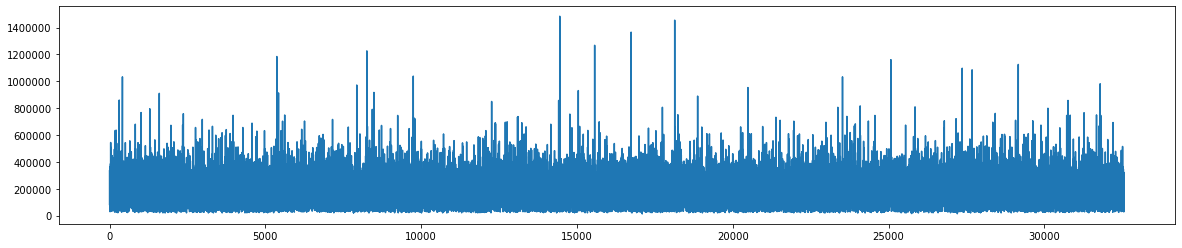

In [77]:
plt.figure(figsize =(20,4))
plt.plot(df[' 77516'])
plt.show()

Соберем пайплайн

In [83]:
data_norm = df.copy()
data_norm[NUM_FEATURE_NAMES] = np.log10(data_norm[NUM_FEATURE_NAMES] + 1)
df = data_norm.copy()

In [90]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]
    

    
continuous_columns = NUM_FEATURE_NAMES
final_transformers = list()
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))
    
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [91]:
regressor = Pipeline([
    ('features',feats),
    ('classifier', LinearRegression()),
])

Модель - линейная регрессия

In [92]:
df.head()

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,1.707570,0,4.920708,0,1.146128,0,0,0,0,0,0.0,0.0,1.146128,0,0
1,1.591065,1,5.333743,1,1.000000,1,1,1,0,0,0.0,0.0,1.612784,0,0
2,1.732394,1,5.370554,2,0.903090,0,1,0,1,0,0.0,0.0,1.612784,0,0
3,1.462398,1,5.529443,0,1.146128,0,2,2,1,1,0.0,0.0,1.612784,1,0
4,1.579784,1,5.454209,3,1.176091,0,0,2,0,1,0.0,0.0,1.612784,0,0


In [93]:
#обучим наш пайплайн
regressor.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('39',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='39')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                (' 77516',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key=' '
                                                                                     '77516')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                (' 13',
                                       

Посчитаем MAE и коэффициент детерминации (R2)

In [94]:
predictions =  regressor.predict(X_test)
 
mean_absolute_error(y_pred=predictions, y_true=y_test), r2_score(y_pred=predictions, y_true=y_test)

(0.3012279165905578, 0.23078587202004408)

In [95]:
intercept = regressor[1].intercept_
features = pd.DataFrame(regressor[1].coef_, 
                        continuous_columns, 
                        columns=['coefficient'])
features.head()

,coefficient
39,0.083022
77516,0.007617
13,0.118389
2174,0.071556
0,0.048873


### SHAP

In [98]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [99]:
model = xgboost.train({"learning_rate": 0.01}, 
                      xgboost.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

График выше показывает вклад каждого признака в предсказание модели относительно базового значения (средний прогноз по всему тренировочному набору данных). 

- Цвет точки - это значение признака
- То, насколько точка далека от вертикальной линии (серой) влево - показывает ее вклад как отрицательный
- То, насколько точка далека от вертикальной линии (серой) вправо - показывает ее положительный вклад

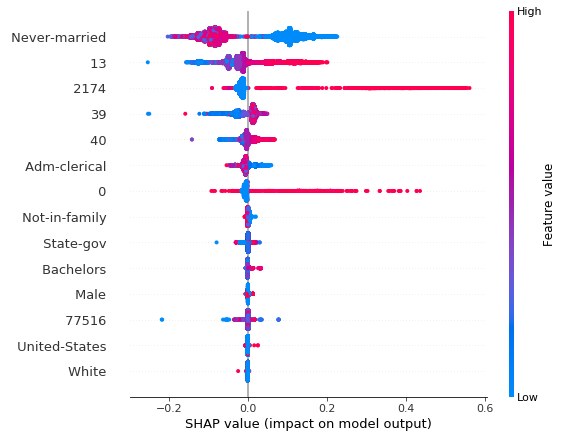

In [100]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

Как его читать: 

- значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
- чем толще линия на графике, тем больше таких точек наблюдения
- чем краснее точка на графике, тем выше значения признака в ней

Из графика можно сделать интересные выводы и проверить их адекватность:
- чем старше человек, тем выше вероятность ухода
- чем признак IsActiveMember выше, то вероятность ухода ниже
- чем выше баланс, тем выше вероятность ухода (?)

Можно даже просто взять средние значения SHAP для каждого признака

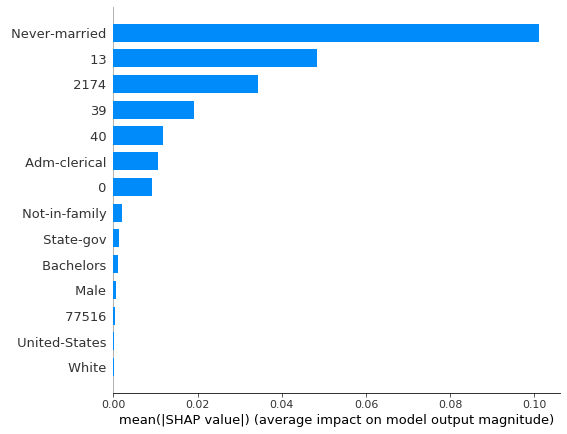

In [101]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

### Домашнее задание

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат


Ссылки:
- Пример с Permutation Importance - https://www.kaggle.com/dansbecker/permutation-importance
- Github проекта SHAP - https://github.com/slundberg/shap
- https://arxiv.org/pdf/1809.04559.pdf
- https://medium.com/civis-analytics/demystifying-black-box-models-with-shap-value-analysis-3e20b536fc80
- https://en.wikipedia.org/wiki/Shapley_value

Feature selection:

1. RFE - recursive feature elimination (есть в sklearn)
2. Boruta - shadow features
3. Target permutation 